# Business Understanding

In this notebook I try to follow methodology CRISP to answer three questions.
These questions are:
    -  How many reviews were made per year?
    - How is the distribution over time about number of reviews per day? there is month with more reviews, there are any season behavior?
    - Who are the first 5 reviewer with more reviews? and what are their names?
    - what are the most positive articles with more than 5 reviews?
    
First, I do a step of data understanding where I explore Nas, unique ids, data types and descriptive of the dataset.
Second, I do the transformations required to answer these questions
Third, I answer these questions.

# Data Understanding

we have to import the python packages

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

First we see the data

In [2]:
rev=pd.read_csv('reviews.csv')
print(rev.shape)
rev.head()

(68275, 6)


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


Second we have to evaluate the quality of the data, repeated rows, type of variables

In [3]:
rev.dtypes

listing_id        int64
id                int64
date             object
reviewer_id       int64
reviewer_name    object
comments         object
dtype: object

All the ids are in numeric which is good but we will have to transform it to string latter to merge data frames. 

Date are not in date format and we will have to transform it
There are any repeated review?

In [4]:
max(pd.crosstab(index=rev["id"],columns="count")['count'])

1

No there aren't any repeated review

## NAs

In [5]:
rev.isna().sum()

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         53
dtype: int64

there are not any NAs

In [6]:
rev.isnull().sum()

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         53
dtype: int64

## IDs

In [7]:
print("There are {} differnt reviewers.".format(str(len(rev['reviewer_id'].unique()))))
print("There are {} reviews.".format(str(len(rev['id'].unique()))))
print("There are {} articles.".format(str(len(rev['listing_id'].unique()))))

There are 63789 differnt reviewers.
There are 68275 reviews.
There are 2829 articles.


## Categorical variables

In this data set the only one categorical variable is the name

In [8]:
len(rev['reviewer_name'].unique())

14775

There are 14775 different names

# Data Preparation

In [9]:
#we generate a new variable were is the year
rev['year']=rev.apply(lambda x: x['date'][:4],axis=1)

In [10]:
#we generate a new variable were is the month
rev['month']=rev.apply(lambda x: x['date'][5:7],axis=1)

In [11]:
#frequency table of date
ta=pd.crosstab(index=rev["date"],columns='count')
table=pd.DataFrame([ta.index.values,ta['count']]).T
table.columns=['date','count']

In [12]:
#we have to tranform date variable to date format
table['date_dateformat']=table.apply(lambda x: datetime.datetime.strptime(x['date'], '%Y-%m-%d'),axis=1)

In [13]:
#cross table year and month
freq_ym=pd.crosstab(index=rev['year'],columns=rev['month'])

In [14]:
#frequency table of reviewer_id
mostRev=pd.crosstab(index=rev["reviewer_id"],columns="count").sort_values(by='count', ascending=False).head()
most_reviewers=pd.DataFrame([mostRev.index.values,mostRev['count']]).T
most_reviewers.columns=['id','count']
most_reviewers['id']=most_reviewers['id'].astype(str)#we have to tranform the data to merge it 

In [15]:
#we make a copy of the dataset to drop duplicates rows
rev3=rev[['reviewer_id','reviewer_name']].copy()
rev3=rev3.drop_duplicates()
rev3['reviewer_id']=rev3['reviewer_id'].astype(str)

# sentiment analysis

In [16]:
#fill na
rev['comments'].fillna(" ", inplace=True)

In [17]:
#we init the class sentimentInitensityAnalyzer
analyser = SentimentIntensityAnalyzer()
#Define the function
def sentiment_analyzer(comment):
    '''
    input:
        - comment a string that will be analized by vaderSentiment
    output 
        - highes scored sentiment (positive, negative,neutral)
    
    references: 
    https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f
    '''
    sentiment=analyser.polarity_scores(comment)
    #this function return 4 variables neg, neutral, positive and compound.
    # - The Positive, Negative and Neutral scores represent the proportion of text that falls 
    #   in these categories. This means our sentence was rated as 67% Positive, 33% Neutral and 0% Negative. 
    #   Hence all these should add up to 1.
    
    # - The Compound score is a metric that calculates the sum of all the lexicon ratings 
    #   which have been normalized between -1(most extreme negative) and +1 (most extreme positive).
    #   In the case above, lexicon ratings for andsupercool are 2.9and respectively1.3. 
    #   The compound score turns out to be 0.75 , denoting a very high positive sentiment.
    
    # https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f
    aux=pd.DataFrame(sentiment,index=[0])
    aux=aux.drop(columns=['compound'])
    score = aux.apply(lambda x: x.argmax(), axis=1)
    return(score)


rev['sentiment']=rev.apply(lambda x: sentiment_analyzer(x['comments']),axis=1)

/Users/alejandro.gonzalez@teradata.com/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


In [18]:
#cross table sentiment and user_id
freq_sent_article=pd.crosstab(index=rev['sentiment'],columns=rev['listing_id'])

In [19]:
def sentiment_per_article(freqtable):
    '''
    input freqtable:ross table sentiment and user_id
    return a data frame with percentaje of positive columns per article.
    
    '''
    
    freqtable=freqtable.T
    freqtable['per_neg']=freqtable['neg']/freqtable.sum(1)
    freqtable['per_pos']=freq_sent_article.T['pos']/freq_sent_article.T.sum(1)
    freqtable['per_neu']=freq_sent_article.T['neu']/freq_sent_article.T.sum(1)
    freqtable['sum']=freq_sent_article.T.sum(1)
    return(freqtable)

In [20]:
#percent of positive reviews per article
per_positive_per=sentiment_per_article(freq_sent_article)

# Aswewring questions

1) How many reviews were made per year?

col_0  count
year        
2009      20
2010     200
2011     664
2012    1316
2013    2965
2014    9272
2015   23814
2016   30024


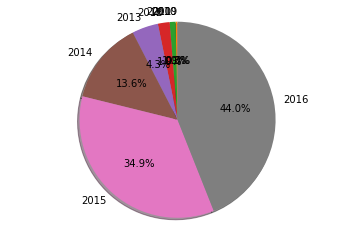

In [21]:
freTable=pd.crosstab(index=rev["year"],columns="count")
freTable.sort_values(by='count', ascending=False)
print(freTable)

#we plot the frequency table in a pie chart
labels = freTable.index.values
sizes = freTable['count']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.show()

44% of the reviews were made in 2016
35% of the reviews were made in 2015
13.6% of the review were made in 2014

2) How is the distribution over time about number of reviews per day? there are any month with more review, there are any season behavior?

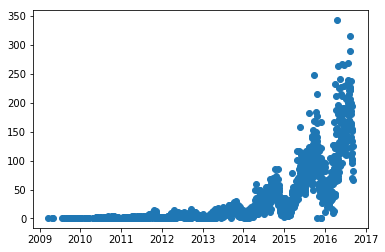

In [22]:
plt.plot_date(table['date_dateformat'], table['count'])

This graph looks like there is a trend so the number of reviews have increased over time in the last couple of years. but it is the same in each mount in different years?

In [23]:
freq_ym

month,01,02,03,04,05,06,07,08,09,10,11,12
year,,,,,,,,,,,,
2009,0,0,1,1,1,0,1,2,3,6,3,2
2010,2,3,3,2,11,8,13,31,37,59,25,6
2011,17,7,20,39,44,56,37,78,102,150,90,24
2012,31,31,93,126,132,157,133,134,145,186,89,59
2013,54,35,91,141,232,283,295,395,396,548,316,179
2014,124,135,273,600,713,775,890,1203,1504,1495,1080,480
2015,500,391,1062,1410,2291,2307,2587,2783,3204,3651,2126,1502
2016,1391,1362,2310,3797,4691,4783,5377,5719,594,0,0,0


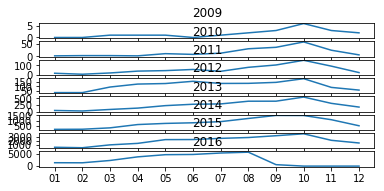

In [24]:
for i in range(freq_ym.shape[0]):
    plt.subplot(12, 1, i+1)
    plt.title(freq_ym.index.values[i])
    plt.plot(freq_ym.iloc[i,])
plt.show()

There is a repetitive behavior over time, every October the Number of reviews increases. The last 5 obs are 0 because we don't have data. I mean, the extraction of this csv was on September 2016 so It is so we don't know the number of reviews one month after the dataset was generated.

3) Who are the first 5 reviewer with more reviews? and what are their names?

In [25]:
most_reviewers.merge(rev3, left_on='id',right_on='reviewer_id')

,id,count,reviewer_id,reviewer_name
0,12096536,37,12096536,Marie
1,40651868,25,40651868,Harry
2,46024609,22,46024609,Joseph
3,52667131,21,52667131,Richard
4,39441871,18,39441871,Doron


Marie made 37 reviews

Harry 25 reviews

Joseph 22 reviews

Richard 21 and Doron 18.

4) what are the most positive articles with more than 5 reviews?


In [26]:
per_positive_per.head(5)

sentiment,neg,neu,pos,per_neg,per_pos,per_neu,sum
listing_id,,,,,,,
3353,0,31,3,0.0,0.088235,0.911765,34
5506,0,34,2,0.0,0.055556,0.944444,36
6695,0,46,1,0.0,0.021277,0.978723,47
6976,0,39,2,0.0,0.048780,0.951220,41
8792,0,17,1,0.0,0.055556,0.944444,18


The most positive articles are:
    - 3353
    - 5506
    - 6695
    - 6976
    - 8792